# Motivation

In this notebook, we will perform a clustering task over a simplified version of the [TrackML](https://www.kaggle.com/c/trackml-particle-identification) dataset, wherein each sample is reduced from $\approx10^5$ points to only $\approx 10^2$ points. TrackML's goal is to reconstruct the trajectory of particles created when proton bunches accelerated to near the speed of light collide. To capture the particles' paths, the particles pass through many layers of a detector (e.g., Atlas), resulting in a point cloud. Successfully clustering this point cloud such that each cluster is associated to one particle is sufficient for physicists to then extract the particles' trajectories and thus discover their kinematic properties.

This notebook presents a simple algorithm that uses a GNN to learn a good embedding for classical clustering algorithm like DBSCAN. While end-to-end and hierarchical clustering is highly desirable, it presents additional challenges which go beyond the scope of this tutorial's purpose in featuring DGL. Interested readers may check out the algorithm introduced in [End-to-End Hierarchical Clustering with Graph Neural Networks](https://cs.nyu.edu/media/publications/choma_nicholas.pdf).

### Pipeline

Graph Neural Networks are an attractive candidate since they are capable of aggregating information over variable-sized neighborhoods of points; there is no limitation of modeling just singular or pairwise interactions. Because we begin only with a point cloud, our pipeline will be as follows:

1. **Metric learning:** Embed the points into a Euclidean space using an MLP on each point indivually. Points belonging to the same particle should be close; points belonging to different particles should be far. *(provided as input data)*
1. **Graph Construction:** Find each point's nearest neighbors in the embedded space, and connect them with a graph. Ensure neighborhoods are large enough to connect most of the points belonging to the same particle. *(provided as input data)*
1. **GNN:** Embed the points into another Euclidean space, this time incorporating neighborhood information. Because each point is aware of its neighbors, the GNN produces a superior embedding to the metric learning stage.
1. **Clustering:** Using the GNN's embedding, cluster the points with DBSCAN. Adjust DBSCAN's hyperparameters until the TrackML score is maximized.

# Loading Data

The dataset consists of detection *events*, wherein a variable number of particles come into contact with the detector's cells. The location of these impacts are called *hits*, and there are likewise a variable number of them per particle.

In [181]:
import pickle
import numpy as np

with open('tracks.pickle', 'rb') as f:
    samples = pickle.load(f)

print("Loaded {} samples.".format(len(samples)))

Loaded 100 samples.


### Features

#### Hits
Each sample contains a set of hits, and each hit contains the following information:

* *x,y,z* coordinates
* Cell count and impact magnitude
* A learned hit embedding, output from the previous graph creation stage
* Ground truth cluster ID, denoting the particle which created the hit

#### Graphs
Additionally, samples contain graphs as output from the previous stage which aims to connect hits created by the same particle. The two graphs included are

* A predicted graph, the raw output from the graph building stage

 - print(type(samples[0]))

* An augmented graph, which contains the predicted graph, plus any connections missed between hits created by the same particle (positive pairs). One could also add some negative pairs to the graph. This is used in the GNN's loss function.

In [182]:
print(samples[0].keys())
print("Hit Key:{}".format(samples[0]['hits'].keys()))
print("Graphs Key:{}".format(samples[0]['graphs'].keys()))
print(type(samples[0]['hier']))
samples[0]['graphs']

dict_keys(['hits', 'graphs', 'hier'])
Hit Key:dict_keys(['xyz', 'cell', 'emb', 'particle_id', 'weight'])
Graphs Key:dict_keys(['pred', 'loss', 'true'])
<class 'list'>


{'pred': array([array([ 0,  1, 96]), array([ 0,  1, 96, 88]),
        array([58, 59, 60, 62, 66,  5,  3,  2,  4,  6, 57,  7, 19]),
        array([58, 59, 60, 62, 66,  5,  3,  2,  4,  6, 57,  7, 19]),
        array([58, 59, 60, 62, 66,  5,  3,  2,  4,  6, 57,  7, 19]),
        array([58, 59, 60, 62, 66,  5,  3,  2,  4,  6, 57,  7, 19]),
        array([58, 59, 60, 62, 66,  5,  3,  2,  4,  6, 57,  7, 19]),
        array([58, 59, 60, 62, 66,  5,  3,  2,  4,  6, 57,  7, 19]),
        array([11, 21, 29, 61, 63, 64, 65, 67, 71,  8, 81, 34, 35, 85, 88, 36]),
        array([21, 20, 63, 64, 65, 67, 71, 81, 34, 85, 88,  9, 27, 28]),
        array([ 30,  38,  10,  12,  93, 102, 104,  23,  97,  39,  72,  82]),
        array([11, 21, 29, 20, 63, 64, 65, 67, 71,  8, 81, 34, 35, 85, 88, 36, 27,
        28]),
        array([ 30,  38,  10,  12,  93, 102, 104,  23,  97,  39,  72,  82]),
        array([ 63,  68,  70,  26,  22,  80,  13,  91,  92,  37,  14,  99, 100]),
        array([ 63,  68,  70,  26,  2

### Visualizations

Choosing a sample to explore, one can see how the embedding differs from the raw features for graph creation.

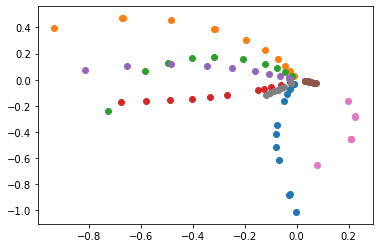

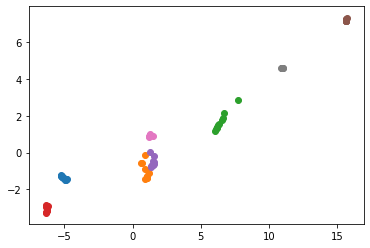

<Figure size 432x288 with 0 Axes>

In [369]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_clusters(x,y,pid):
    for g in np.unique(pid):
        i = np.where(pid == g)
        plt.scatter(x[i],y[i], label=g)
    plt.show()
    plt.clf()

hits = samples[1]['hits']
xyz = hits['xyz']
emb = hits['emb']
pid = hits['particle_id']

# Original Hit coordinates
plot_clusters(xyz[:,0], xyz[:,1], pid)

# Metric Learning-based Emb coordinates
plot_clusters(emb[:,0], emb[:,1], pid)

### Embedding Model

To create this embedding, an MLP is trained to trainsform one hit into its embedded representation. Hinge loss over pairs of embedded hits supervises the MLP's learning process. To keep this tutorial succinct, the MLP embedding is included in the dataset, the MLP having been already trained.

Clearly, the embedding will lead to superior clustering as compared with the raw *x,y,z* positions. 
However, this embedding incorporates information from only each hit individually. 
With a GNN, one can create embeddings which incorporate information from the hit's neighborhood. 
As we will see, this allows for superior embeddings and thus improved performance in clustering.

# Graph

Once each point is embedded, the following steps occur in building a graph:

1. Build a k-d tree with the embedded points.
1. Query the neighborhood of every point, specifying either $k$, the number of neighbors, or $\epsilon$, the size of the neighborhood around each point. In practice, $\epsilon$-ball neighborhoods produce favorable results.
1. Connect each point to its neighbors with an undirected graph.

In keeping this tutorial succinct, these steps are already performed and the graph for each sample is included in the dataset.

<img src="img/graph.png">

# Model

The GNN model chosen is a simple message-passing architecture. One layer concatenates each node's features with an aggregation of the node's neighborhood, before applying a transformation via a fully-connected neural network layer.

The output of the model is a set of node embeddings, where this new embedding has the same goal as in the graph building stage: according to some distance metric, node pairs whose hits belong to the same particle should be close, and otherwise they should be far.

In [101]:
import dgl
import torch
import torch.nn as nn

### Graph Weighting
A multi-layer preceptron kernel determines edge weights of the graph at each layer.
Here, each edge is represented by the features of its adjoining nodes.
These features are passed through the MLP to produce an edge weight between 0 and 1.

Consider the feature vectors of any two nodes, $x_i$ and $x_j$, which have an edge between them.
Then their edge weight $w_{ij}$ is given as

$$
\begin{align}
w_{ij} &= \text{sigmoid}(f([x_i, x_j])),
\end{align}
$$

where $f$ is an MLP as defined in the graph weighting kernel.

## Architecture
- ReLU(Linear(nb_input*2, nb_hidden of e_feat))
- -> ReLU(Linear(nb_hidden, nb_hidden of e_feat))
- -> Sigmoid(Linear(nb_hidden, nb_output of e_feat))

In [121]:
class MLP_Kernel_DGL(nn.Module):
    def __init__(self, nb_input, nb_hidden_gnn, nb_output=1, nb_layer=1):
        super(MLP_Kernel_DGL, self).__init__()
        
        layers = [nn.Linear(nb_input*2, nb_hidden_gnn)]
        for _ in range(nb_layer-1):
            layers.append(nn.Linear(nb_hidden_gnn, nb_hidden_gnn))
        layers.append(nn.Linear(nb_hidden_gnn, nb_output))
        
        self.layers = nn.ModuleList(layers)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()

    def forward(self, g):
        g.apply_edges(self.mlp)
        return g

    def mlp(self, edges):
        # Gather features from all relevant node pairs
        src = edges.src['feat']
        dst = edges.dst['feat']
        e_feats = torch.cat((src,dst),dim=1)
        
        # Apply MLP layers to node pairs
        for l in self.layers[:-1]:
            e_feats = self.act1(l(e_feats))
        
        # Apply final output with sigmoid
        e_feats = self.layers[-1](e_feats)
        e_feats = self.act2(e_feats)
        return {'e' : e_feats}

### GNN Layer
Each GNN layer first, if applicable, normalizes the incoming graph nodes, updates the graph weighting based on that layer's edge weight kernel, then applies graph convolution.

Consider node $i$ at a given layer, and the neighborhood of $i$ given as $N_i$.
Then the feature vector $x_i$ is updated to $x'_i$ in the following way.
First, incoming messages to $i$ are weighted and aggregated:

$$
\begin{align}
z_i = \sum_{j \in N_i} w_{ij} * x_{j}.
\end{align}
$$

Next, $x_i$ and $z_i$ are concatenated and transformed:

$$
\begin{align}
x'_i = \text{ReLU}(\phi([x_i, z_i])),
\end{align}
$$

where $\phi$ is a learned affine transformation.

## Arhictecture
#### ReLU(Linear(2*input_dimn, nb_hidden of BachNorm(Edge_Weighting(node_feats))))

In [113]:
# Complete GNN layer, including normalization, graph weighting, and convolution
class GNN_Layer(nn.Module):
    def __init__(self, input_dim, nb_hidden_gnn, nb_hidden_kernel, apply_norm=True):
        super(GNN_Layer, self).__init__()

        self.edge_weighting = MLP_Kernel_DGL(input_dim, nb_hidden_kernel)
        self.bn = nn.BatchNorm1d(input_dim,momentum=0.10) if apply_norm else None
        self.fc = nn.Linear(2*input_dim, nb_hidden_gnn)
        self.act = nn.ReLU()

    def forward(self, g, features):
        # maybe apply normalization
        if self.bn is not None:
            features = self.bn(features)
        g.ndata['feat'] = features

        # set edge weights for this layer
        g = self.edge_weighting(g)
        
        # send weighted messages and apply graph convolution to nodes
        g.update_all(message_func=dgl.function.u_mul_e('feat', 'e', 'msg'),
                     reduce_func=dgl.function.sum('msg', 'agg_msg'))
        
        # concat and apply an affine transformation
        node_feats = torch.cat((features, g.ndata['agg_msg']), dim=1)
        emb = self.fc(node_feats)
        emb = self.act(emb)
        
        return emb

### GNN
The GNN consists of several layers as defined above. 
A final embedding layer takes the node features as output by the GNN layers, and applies an affine transformation to a low dimension space as defined by emb_dim.

In [114]:
class GNN(nn.Module):
    def __init__(self, nb_hidden_gnn, nb_layer, nb_hidden_kernel, input_dim, emb_dim=2):
        super(GNN, self).__init__()

        # Construct GNN Layers
        gnn_layers = [GNN_Layer(input_dim, nb_hidden_gnn, nb_hidden_kernel, apply_norm=True)]
        for _ in range(nb_layer-1):
            gnn_layers.append(GNN_Layer(nb_hidden_gnn, nb_hidden_gnn, nb_hidden_kernel))
        self.layers = nn.ModuleList(gnn_layers)

        self.final_emb = nn.Linear(nb_hidden_gnn, emb_dim)

    def forward(self, g):
        emb = g.ndata.pop('feat')
        for i, layer in enumerate(self.layers):
            emb = layer(g, emb)
        emb = self.final_emb(emb)
        return emb

# Training

## Dataset, Dataloader

The TrackML_Dataset class is a PyTorch Dataset subclass, for use in a DataLoader class.
The trackml_collate function should be used when instantiating the DataLoader class for minibatch training.

Each sample will contain a graph (with features) used as input, and a graph with ground truth information.

In [277]:
from gnn_utils import TrackML_Dataset

def trackml_collate(samples):
    g_input = [s[0] for s in samples]
    g_input = dgl.batch(g_input)

    g_true = [s[1] for s in samples]
    g_true = dgl.batch(g_true)

    return g_input, g_true

This collate function makes use of DGL's batch functionality, allowing computation over minibatches of variable-sized graphs.

## Setup for DataLoader and GNN Model

In [320]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

# PARAMETERS
batch_size = 4
nb_hidden = 32
nb_layers = 4
learn_rate = 0.001

dataset = TrackML_Dataset(samples)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        collate_fn=trackml_collate,
                        drop_last=True, 
                        shuffle=True,
                        num_workers=0)

net = GNN(nb_hidden_gnn=nb_hidden, nb_layer=nb_layers, nb_hidden_kernel=nb_hidden, input_dim=6)
optim = torch.optim.Adamax(params=net.parameters(), lr=learn_rate)

In [281]:
optim

Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [284]:
print(net)

GNN(
  (layers): ModuleList(
    (0): GNN_Layer(
      (edge_weighting): MLP_Kernel_DGL(
        (layers): ModuleList(
          (0): Linear(in_features=12, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=1, bias=True)
        )
        (act1): ReLU()
        (act2): Sigmoid()
      )
      (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc): Linear(in_features=12, out_features=32, bias=True)
      (act): ReLU()
    )
    (1): GNN_Layer(
      (edge_weighting): MLP_Kernel_DGL(
        (layers): ModuleList(
          (0): Linear(in_features=64, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=1, bias=True)
        )
        (act1): ReLU()
        (act2): Sigmoid()
      )
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc): Linear(in_features=64, out_features=32, bias=True)
      (act): ReLU()
    )
    (2): GNN_Layer(
      (edge_we

### Loss
Hinge embedding loss produces embeddings which are amenable to clustering, since they only penalize false pairs when the distance between false pairs becomes small.
The hinge loss is stated as:

$
        l = \begin{cases}
            x, & \text{if}\; y = 1,\\
            \max \{0, \Delta - x\}, & \text{if}\; y = -1,
        \end{cases}
$
where $x$ is the prediction measuring similarity, and $y$ is the target $\in \{-1,1\}$.

Here a DGL edge function is used.

In [27]:
def get_emb_for_loss(edges):
    src = edges.src['emb']
    dst = edges.dst['emb']
    pred_dist = nn.functional.pairwise_distance(src, dst)
    truth = edges.data['truth']
    true_dist = truth*2 - 1
    loss = nn.functional.hinge_embedding_loss(pred_dist, true_dist, reduction='none')
    return {'loss' : loss, 'pred_dist' : pred_dist, 'true_dist' : true_dist}

### Accuracy
An accuracy proxy helps as a sanity check during training.

In [28]:
def score_dist_accuracy(pred, true):
    pred = pred.round()
    pred[pred!=0] = 1
    pred = 1-pred
    correct = pred==true
    nb_correct = correct.sum()
    nb_total = true.size(0)
    score = float(nb_correct.item()) / nb_total
    return score

### Training
Train over the dataset for a few epochs. 

In [321]:
def train_one_epoch(net, batch_size, optimizer, train_loader):
    net.train()

    nb_batch = len(train_loader)
    nb_train = nb_batch * batch_size
    epoch_score = 0
    epoch_loss  = 0

    print("\nTraining on {} samples".format(nb_train))
    for i, (g_input, g_true) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # forward the GNN model on the input graph and set the result to the augmented graph
        g_true.ndata['emb'] = net(g_input)
        
        # compute loss function over the augmented graph
        g_true.apply_edges(get_emb_for_loss)
        loss = g_true.edata.pop('loss').mean()
        score = score_dist_accuracy(g_true.edata.pop('pred_dist'), g_true.edata.pop('truth'))

        loss.backward()
        optimizer.step()

        epoch_score += score * 100
        epoch_loss  += loss.item()

        nb_proc = (i+1) * batch_size
        if (((i+1) % (nb_batch//2)) == 0):
            print("  {:2d}  Loss: {:.3f}  Acc: {:2.1f}".format(nb_proc, epoch_loss/(i+1), epoch_score/(i+1)))
    return epoch_loss / nb_batch, epoch_score / nb_batch

for i in range(10):
    train_one_epoch(net, batch_size, optim, dataloader)


Training on 100 samples
  48  Loss: 0.220  Acc: 78.7
  96  Loss: 0.177  Acc: 83.5

Training on 100 samples
  48  Loss: 0.086  Acc: 92.5
  96  Loss: 0.082  Acc: 93.2

Training on 100 samples
  48  Loss: 0.062  Acc: 95.8
  96  Loss: 0.066  Acc: 94.9

Training on 100 samples
  48  Loss: 0.057  Acc: 96.1
  96  Loss: 0.058  Acc: 95.9

Training on 100 samples
  48  Loss: 0.058  Acc: 95.4
  96  Loss: 0.059  Acc: 95.5

Training on 100 samples
  48  Loss: 0.050  Acc: 96.1
  96  Loss: 0.054  Acc: 96.0

Training on 100 samples
  48  Loss: 0.052  Acc: 96.2
  96  Loss: 0.057  Acc: 95.7

Training on 100 samples
  48  Loss: 0.050  Acc: 96.4
  96  Loss: 0.051  Acc: 96.3

Training on 100 samples
  48  Loss: 0.049  Acc: 96.7
  96  Loss: 0.050  Acc: 96.3

Training on 100 samples
  48  Loss: 0.051  Acc: 96.1
  96  Loss: 0.052  Acc: 96.1


# Clustering

In [371]:
dataloader = DataLoader(dataset, batch_size=1, collate_fn=trackml_collate)

# Embed samples
orig_xyz = []
emb_metric = []
emb_gnn = []
pid = []
weight = []
net.eval()
with torch.autograd.no_grad():
    for i, (g_input, g_true) in enumerate(dataloader):
        f = g_input.ndata['feat']
        pid.append(g_input.ndata['pid'])
        
        ## Original XYZ (Shape = (-1, 3))
        orig_xyz.append(g_input.ndata['feat'][:,:3])
        
        ## Metric Embeddings (Shape = (-1, 3))
        emb_metric.append(g_input.ndata['feat'][:,3:])
        weight.append(g_input.ndata['weight'])
        
        #GNN Embeddings (Shape = (-1, 2))
        hits_emb = net(g_input)
        emb_gnn.append(hits_emb.numpy())

In [366]:
hits_emb.shape

torch.Size([99, 2])

As a sanity check, visualize the tracks in the original space, metric learning embedding, and GNN embedding.
Not that the metric learning model was trained for many hours on GPU, while training the GNN in this notebook is quite limited.

In [367]:
orig_xyz[0].shape

torch.Size([107, 3])

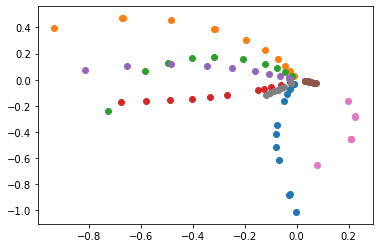

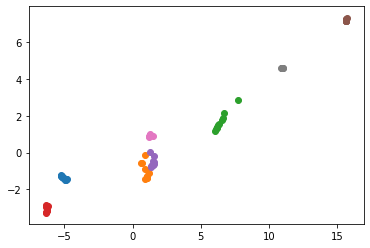

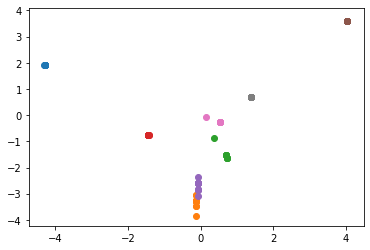

<Figure size 432x288 with 0 Axes>

In [372]:
j = 1
to_plot = [orig_xyz[j], emb_metric[j], emb_gnn[j]]
for emb in to_plot:
    plot_clusters(emb[:,0], emb[:,1], pid[j])

In [374]:
# Cluster
from sklearn.cluster import DBSCAN

c = DBSCAN(eps=.24, min_samples=3)

def get_clusters(embedding):
    return c.fit_predict(embedding)

# Scoring
The score of one predicted cluster is nonzero only if a large majority of its points belong to the same true cluster, and if the majority of the true cluster is contained within the predicted cluster.  A perfect clustering will thus lead to a score of 1, while a random clustering will almost certainly have a score of 0.

In [375]:
# Score samples
from gnn_utils import score_event

In [380]:
### Get final cluster scores
import pandas

avg_score = 0.0
nb_samples = 20
for i in range(nb_samples):
    # emb = samples[i]['hits']['emb']
    # clusters = get_clusters(emb)
    clusters = get_clusters(emb_gnn[i])
    hit_ids = np.arange(len(clusters))
    truth = pandas.DataFrame.from_dict({'particle_id':pid[i].numpy(),
                                        'hit_id':hit_ids,
                                        'weight':weight[i].numpy()})
    submission = pandas.DataFrame.from_dict({'hit_id':hit_ids,
                                             'track_id':clusters})
    score = score_event(truth, submission)
    avg_score += score
print("TrackML score: {:.2f}".format(avg_score / nb_samples))

TrackML score: 0.88


In [386]:
truth

,particle_id,hit_id,weight
0,1.801530e+17,0,0.000015
1,1.801530e+17,1,0.000013
2,2.657135e+17,2,0.000007
3,2.657135e+17,3,0.000007
4,1.531271e+17,4,0.000005
...,...,...,...
98,9.457772e+16,98,0.000014
99,9.457772e+16,99,0.000012
100,7.160772e+17,100,0.000014
101,7.160772e+17,101,0.000011
